In [1]:
from src.models.data_augmentation.VAE import *
from src.models.data_augmentation.WAE import *
from src.models.data_augmentation.GAN import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.evaluation import *

In [3]:
dataset_path = "data/data_combined_controls.csv"

In [4]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)

vae = train_vae(dataset, original_dim)
augmented_df = generate_vae(vae, scaled_data.columns, scaler)

/Users/carolkiekhaefer10-2023/anaconda3/envs/pytorchenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training VAE: 100%|██████████| 100/100 [00:00<00:00, 120.29it/s]


In [6]:
compare_stats_df = compare_statistics(scaled_data, augmented_df)
compare_distributions_df = compare_distributions(scaled_data, augmented_df)

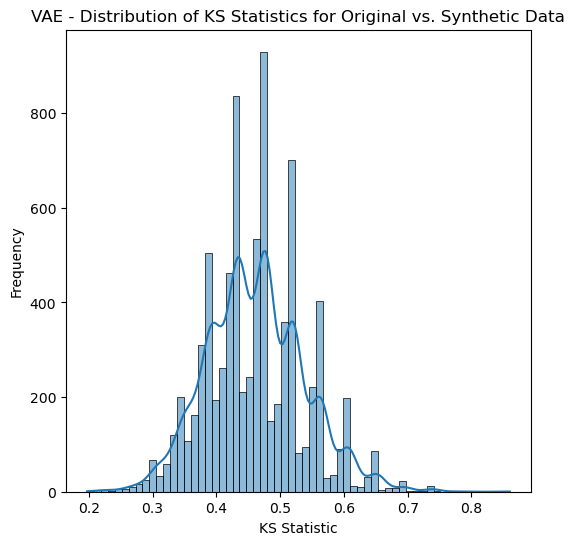

In [7]:
plt.figure(figsize=(6, 6))
sns.histplot(compare_distributions_df['KS Statistic'], kde=True)
plt.title('VAE - Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

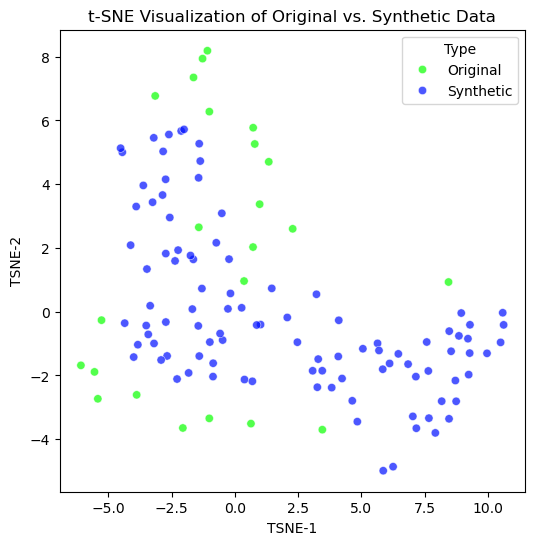

In [8]:
generate_tsne(scaled_data, augmented_df)

# WAE

In [9]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)

wae = train_wae(dataset, original_dim)
augmented_df = generate_wae(wae, scaled_data.columns, scaler)

Training WAE: 100%|██████████| 100/100 [00:00<00:00, 121.95it/s]


In [10]:
compare_stats_df = compare_statistics(scaled_data, augmented_df)
compare_distributions_df = compare_distributions(scaled_data, augmented_df)

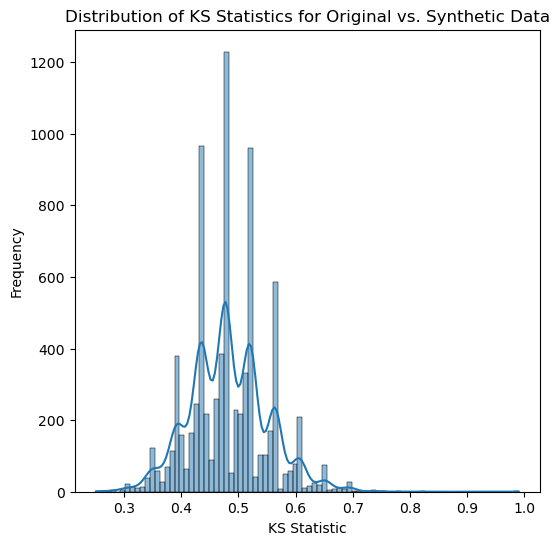

In [11]:
plt.figure(figsize=(6, 6))
sns.histplot(compare_distributions_df['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

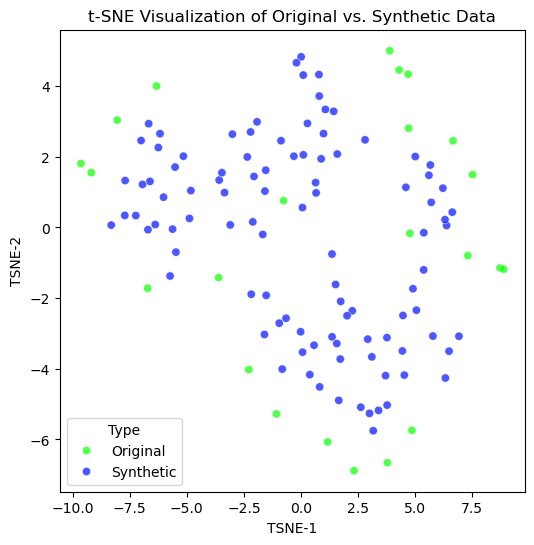

In [12]:
generate_tsne(scaled_data, augmented_df)

# WGAN

Training WGAN-GP:   1%|          | 1/100 [00:07<12:58,  7.86s/it]

Epoch: 0, Batch: 0, G_loss: 19.241731643676758, C_loss: -116.00824737548828


Training WGAN-GP:   2%|▏         | 2/100 [00:15<12:56,  7.93s/it]

Epoch: 1, Batch: 0, G_loss: -18.68366241455078, C_loss: -42.834285736083984


Training WGAN-GP:   3%|▎         | 3/100 [00:23<12:51,  7.95s/it]

Epoch: 2, Batch: 0, G_loss: 0.005696003325283527, C_loss: 5.21778678894043


Training WGAN-GP:   4%|▍         | 4/100 [00:32<12:53,  8.06s/it]

Epoch: 3, Batch: 0, G_loss: 33.933082580566406, C_loss: -29.45156478881836


Training WGAN-GP:   5%|▌         | 5/100 [00:39<12:42,  8.02s/it]

Epoch: 4, Batch: 0, G_loss: 70.55614471435547, C_loss: -55.27845764160156


Training WGAN-GP:   6%|▌         | 6/100 [00:47<12:30,  7.98s/it]

Epoch: 5, Batch: 0, G_loss: 125.44099426269531, C_loss: -144.893798828125


Training WGAN-GP:   7%|▋         | 7/100 [00:55<12:22,  7.99s/it]

Epoch: 6, Batch: 0, G_loss: 95.4040298461914, C_loss: -79.93730163574219


Training WGAN-GP:   8%|▊         | 8/100 [01:03<12:12,  7.96s/it]

Epoch: 7, Batch: 0, G_loss: 59.423377990722656, C_loss: -102.31199645996094


Training WGAN-GP:   9%|▉         | 9/100 [01:11<12:03,  7.96s/it]

Epoch: 8, Batch: 0, G_loss: -30.955961227416992, C_loss: -176.205078125


Training WGAN-GP:  10%|█         | 10/100 [01:19<11:57,  7.97s/it]

Epoch: 9, Batch: 0, G_loss: -87.47650909423828, C_loss: -58.164459228515625


Training WGAN-GP:  11%|█         | 11/100 [01:27<11:54,  8.03s/it]

Epoch: 10, Batch: 0, G_loss: -94.7201919555664, C_loss: -397.0855407714844


Training WGAN-GP:  12%|█▏        | 12/100 [01:36<11:50,  8.07s/it]

Epoch: 11, Batch: 0, G_loss: -41.51799392700195, C_loss: -162.6767120361328


Training WGAN-GP:  13%|█▎        | 13/100 [01:44<11:40,  8.05s/it]

Epoch: 12, Batch: 0, G_loss: 85.33855438232422, C_loss: -80.70085906982422


Training WGAN-GP:  14%|█▍        | 14/100 [01:52<11:36,  8.10s/it]

Epoch: 13, Batch: 0, G_loss: 87.67532348632812, C_loss: 73.8241958618164


Training WGAN-GP:  15%|█▌        | 15/100 [02:00<11:26,  8.08s/it]

Epoch: 14, Batch: 0, G_loss: 86.96202850341797, C_loss: -127.1713638305664


Training WGAN-GP:  16%|█▌        | 16/100 [02:08<11:19,  8.09s/it]

Epoch: 15, Batch: 0, G_loss: 118.44001770019531, C_loss: -104.41673278808594


Training WGAN-GP:  17%|█▋        | 17/100 [02:16<11:15,  8.14s/it]

Epoch: 16, Batch: 0, G_loss: 125.58821105957031, C_loss: -138.01898193359375


Training WGAN-GP:  18%|█▊        | 18/100 [02:24<11:08,  8.15s/it]

Epoch: 17, Batch: 0, G_loss: 149.40528869628906, C_loss: -308.5711975097656


Training WGAN-GP:  19%|█▉        | 19/100 [02:32<10:57,  8.12s/it]

Epoch: 18, Batch: 0, G_loss: 75.27335357666016, C_loss: 24.175838470458984


Training WGAN-GP:  20%|██        | 20/100 [02:41<10:52,  8.16s/it]

Epoch: 19, Batch: 0, G_loss: 24.315523147583008, C_loss: -124.48683166503906


Training WGAN-GP:  21%|██        | 21/100 [02:49<10:40,  8.11s/it]

Epoch: 20, Batch: 0, G_loss: 23.128650665283203, C_loss: -48.38544464111328


Training WGAN-GP:  22%|██▏       | 22/100 [02:57<10:30,  8.08s/it]

Epoch: 21, Batch: 0, G_loss: 42.89686584472656, C_loss: -78.4588623046875


Training WGAN-GP:  23%|██▎       | 23/100 [03:05<10:17,  8.01s/it]

Epoch: 22, Batch: 0, G_loss: 63.83848190307617, C_loss: -140.48135375976562


Training WGAN-GP:  24%|██▍       | 24/100 [03:13<10:10,  8.04s/it]

Epoch: 23, Batch: 0, G_loss: 75.88045501708984, C_loss: -328.1826477050781


Training WGAN-GP:  25%|██▌       | 25/100 [03:20<09:59,  7.99s/it]

Epoch: 24, Batch: 0, G_loss: 86.5358657836914, C_loss: -60.70549011230469


Training WGAN-GP:  26%|██▌       | 26/100 [03:28<09:49,  7.97s/it]

Epoch: 25, Batch: 0, G_loss: 94.99060821533203, C_loss: -275.5351867675781


Training WGAN-GP:  27%|██▋       | 27/100 [03:36<09:39,  7.94s/it]

Epoch: 26, Batch: 0, G_loss: 35.1689338684082, C_loss: 96.2231216430664


Training WGAN-GP:  28%|██▊       | 28/100 [03:44<09:32,  7.96s/it]

Epoch: 27, Batch: 0, G_loss: -17.32691192626953, C_loss: 4.562057971954346


Training WGAN-GP:  29%|██▉       | 29/100 [03:52<09:21,  7.91s/it]

Epoch: 28, Batch: 0, G_loss: -35.43177795410156, C_loss: -19.454631805419922


Training WGAN-GP:  30%|███       | 30/100 [04:00<09:15,  7.93s/it]

Epoch: 29, Batch: 0, G_loss: -70.29039001464844, C_loss: -313.6128234863281


Training WGAN-GP:  31%|███       | 31/100 [04:08<09:02,  7.86s/it]

Epoch: 30, Batch: 0, G_loss: -67.50718688964844, C_loss: -142.79171752929688


Training WGAN-GP:  32%|███▏      | 32/100 [04:15<08:50,  7.80s/it]

Epoch: 31, Batch: 0, G_loss: -22.94065284729004, C_loss: -67.41606903076172


Training WGAN-GP:  33%|███▎      | 33/100 [04:23<08:46,  7.85s/it]

Epoch: 32, Batch: 0, G_loss: -1.02291738986969, C_loss: -109.82806396484375


Training WGAN-GP:  34%|███▍      | 34/100 [04:31<08:35,  7.80s/it]

Epoch: 33, Batch: 0, G_loss: 7.7388529777526855, C_loss: -132.657958984375


Training WGAN-GP:  35%|███▌      | 35/100 [04:39<08:25,  7.78s/it]

Epoch: 34, Batch: 0, G_loss: 0.8814102411270142, C_loss: -27.26526641845703


Training WGAN-GP:  36%|███▌      | 36/100 [04:47<08:16,  7.75s/it]

Epoch: 35, Batch: 0, G_loss: -10.326026916503906, C_loss: -67.53704833984375


Training WGAN-GP:  37%|███▋      | 37/100 [04:54<08:07,  7.74s/it]

Epoch: 36, Batch: 0, G_loss: -17.3566837310791, C_loss: -47.14106369018555


Training WGAN-GP:  38%|███▊      | 38/100 [05:02<07:58,  7.72s/it]

Epoch: 37, Batch: 0, G_loss: -32.7838020324707, C_loss: -274.8198547363281


Training WGAN-GP:  39%|███▉      | 39/100 [05:09<07:48,  7.68s/it]

Epoch: 38, Batch: 0, G_loss: -32.01531982421875, C_loss: 18.09137725830078


Training WGAN-GP:  40%|████      | 40/100 [05:17<07:37,  7.62s/it]

Epoch: 39, Batch: 0, G_loss: -18.959070205688477, C_loss: -59.73200988769531


Training WGAN-GP:  41%|████      | 41/100 [05:24<07:27,  7.59s/it]

Epoch: 40, Batch: 0, G_loss: -15.924880027770996, C_loss: -212.23956298828125


Training WGAN-GP:  42%|████▏     | 42/100 [05:32<07:21,  7.60s/it]

Epoch: 41, Batch: 0, G_loss: -15.382999420166016, C_loss: -17.319473266601562


Training WGAN-GP:  43%|████▎     | 43/100 [05:40<07:14,  7.63s/it]

Epoch: 42, Batch: 0, G_loss: -16.330842971801758, C_loss: -47.77497863769531


Training WGAN-GP:  44%|████▍     | 44/100 [05:48<07:12,  7.72s/it]

Epoch: 43, Batch: 0, G_loss: -10.33056640625, C_loss: 10.300031661987305


Training WGAN-GP:  45%|████▌     | 45/100 [05:55<07:03,  7.70s/it]

Epoch: 44, Batch: 0, G_loss: -0.3345820903778076, C_loss: -19.531892776489258


Training WGAN-GP:  46%|████▌     | 46/100 [06:03<06:59,  7.78s/it]

Epoch: 45, Batch: 0, G_loss: 2.7694737911224365, C_loss: -207.98316955566406


Training WGAN-GP:  47%|████▋     | 47/100 [06:11<06:48,  7.71s/it]

Epoch: 46, Batch: 0, G_loss: 7.904607772827148, C_loss: -101.60539245605469


Training WGAN-GP:  48%|████▊     | 48/100 [06:19<06:43,  7.75s/it]

Epoch: 47, Batch: 0, G_loss: 27.872621536254883, C_loss: -61.9346923828125


Training WGAN-GP:  49%|████▉     | 49/100 [06:26<06:33,  7.72s/it]

Epoch: 48, Batch: 0, G_loss: 59.080074310302734, C_loss: -58.9267463684082


Training WGAN-GP:  50%|█████     | 50/100 [06:34<06:25,  7.71s/it]

Epoch: 49, Batch: 0, G_loss: 94.4517593383789, C_loss: -314.58538818359375


Training WGAN-GP:  51%|█████     | 51/100 [06:42<06:16,  7.68s/it]

Epoch: 50, Batch: 0, G_loss: 141.942626953125, C_loss: -100.66765594482422


Training WGAN-GP:  52%|█████▏    | 52/100 [06:49<06:08,  7.68s/it]

Epoch: 51, Batch: 0, G_loss: 195.2011260986328, C_loss: -362.05926513671875


Training WGAN-GP:  53%|█████▎    | 53/100 [06:57<06:04,  7.75s/it]

Epoch: 52, Batch: 0, G_loss: 99.1463394165039, C_loss: 221.81051635742188


Training WGAN-GP:  54%|█████▍    | 54/100 [07:05<05:57,  7.77s/it]

Epoch: 53, Batch: 0, G_loss: 28.138341903686523, C_loss: -20.144508361816406


Training WGAN-GP:  55%|█████▌    | 55/100 [07:13<05:50,  7.80s/it]

Epoch: 54, Batch: 0, G_loss: 3.136122941970825, C_loss: -63.86318588256836


Training WGAN-GP:  56%|█████▌    | 56/100 [07:21<05:43,  7.82s/it]

Epoch: 55, Batch: 0, G_loss: -2.6021077632904053, C_loss: -27.902854919433594


Training WGAN-GP:  57%|█████▋    | 57/100 [07:29<05:38,  7.87s/it]

Epoch: 56, Batch: 0, G_loss: -0.021833542734384537, C_loss: -13.69991683959961


Training WGAN-GP:  58%|█████▊    | 58/100 [07:37<05:32,  7.92s/it]

Epoch: 57, Batch: 0, G_loss: 6.202857494354248, C_loss: -87.40376281738281


Training WGAN-GP:  59%|█████▉    | 59/100 [07:45<05:23,  7.90s/it]

Epoch: 58, Batch: 0, G_loss: 6.225627422332764, C_loss: -93.0297622680664


Training WGAN-GP:  60%|██████    | 60/100 [07:53<05:15,  7.89s/it]

Epoch: 59, Batch: 0, G_loss: 1.0549743175506592, C_loss: -61.22935485839844


Training WGAN-GP:  61%|██████    | 61/100 [08:00<05:07,  7.88s/it]

Epoch: 60, Batch: 0, G_loss: 4.009161472320557, C_loss: -116.52689361572266


Training WGAN-GP:  62%|██████▏   | 62/100 [08:08<05:00,  7.92s/it]

Epoch: 61, Batch: 0, G_loss: 20.152820587158203, C_loss: -56.79302978515625


Training WGAN-GP:  63%|██████▎   | 63/100 [08:16<04:50,  7.85s/it]

Epoch: 62, Batch: 0, G_loss: 32.96800994873047, C_loss: -150.0311737060547


Training WGAN-GP:  64%|██████▍   | 64/100 [08:24<04:40,  7.80s/it]

Epoch: 63, Batch: 0, G_loss: 14.949539184570312, C_loss: -51.12046813964844


Training WGAN-GP:  65%|██████▌   | 65/100 [08:31<04:30,  7.73s/it]

Epoch: 64, Batch: 0, G_loss: 0.2992086112499237, C_loss: -66.86119079589844


Training WGAN-GP:  66%|██████▌   | 66/100 [08:39<04:20,  7.67s/it]

Epoch: 65, Batch: 0, G_loss: 16.219383239746094, C_loss: -80.76152801513672


Training WGAN-GP:  67%|██████▋   | 67/100 [08:47<04:15,  7.73s/it]

Epoch: 66, Batch: 0, G_loss: 4.956015110015869, C_loss: -124.00752258300781


Training WGAN-GP:  68%|██████▊   | 68/100 [08:55<04:07,  7.74s/it]

Epoch: 67, Batch: 0, G_loss: -8.652682304382324, C_loss: -261.7633361816406


Training WGAN-GP:  69%|██████▉   | 69/100 [09:02<04:00,  7.75s/it]

Epoch: 68, Batch: 0, G_loss: 9.284127235412598, C_loss: -26.300796508789062


Training WGAN-GP:  70%|███████   | 70/100 [09:10<03:52,  7.75s/it]

Epoch: 69, Batch: 0, G_loss: 9.959043502807617, C_loss: -58.19235610961914


Training WGAN-GP:  71%|███████   | 71/100 [09:18<03:45,  7.78s/it]

Epoch: 70, Batch: 0, G_loss: 13.794546127319336, C_loss: -73.34254455566406


Training WGAN-GP:  72%|███████▏  | 72/100 [09:26<03:37,  7.75s/it]

Epoch: 71, Batch: 0, G_loss: 13.697277069091797, C_loss: -207.4104461669922


Training WGAN-GP:  73%|███████▎  | 73/100 [09:34<03:31,  7.84s/it]

Epoch: 72, Batch: 0, G_loss: 9.575525283813477, C_loss: -52.57761001586914


Training WGAN-GP:  74%|███████▍  | 74/100 [09:42<03:25,  7.90s/it]

Epoch: 73, Batch: 0, G_loss: 11.693628311157227, C_loss: 85.61389923095703


Training WGAN-GP:  75%|███████▌  | 75/100 [09:50<03:19,  7.97s/it]

Epoch: 74, Batch: 0, G_loss: 3.3109748363494873, C_loss: -61.39691925048828


Training WGAN-GP:  76%|███████▌  | 76/100 [09:58<03:12,  8.04s/it]

Epoch: 75, Batch: 0, G_loss: 7.756398677825928, C_loss: -13.33319091796875


Training WGAN-GP:  77%|███████▋  | 77/100 [10:06<03:05,  8.08s/it]

Epoch: 76, Batch: 0, G_loss: 14.997965812683105, C_loss: -96.37165832519531


Training WGAN-GP:  78%|███████▊  | 78/100 [10:14<02:58,  8.09s/it]

Epoch: 77, Batch: 0, G_loss: 15.183426856994629, C_loss: -86.36553192138672


Training WGAN-GP:  79%|███████▉  | 79/100 [10:22<02:50,  8.10s/it]

Epoch: 78, Batch: 0, G_loss: 23.519081115722656, C_loss: -141.05413818359375


Training WGAN-GP:  80%|████████  | 80/100 [10:31<02:42,  8.11s/it]

Epoch: 79, Batch: 0, G_loss: 30.182697296142578, C_loss: -94.80927276611328


Training WGAN-GP:  81%|████████  | 81/100 [10:39<02:36,  8.22s/it]

Epoch: 80, Batch: 0, G_loss: 41.52961349487305, C_loss: -143.26649475097656


Training WGAN-GP:  82%|████████▏ | 82/100 [10:47<02:27,  8.18s/it]

Epoch: 81, Batch: 0, G_loss: 10.933993339538574, C_loss: -66.18363952636719


Training WGAN-GP:  83%|████████▎ | 83/100 [10:55<02:19,  8.21s/it]

Epoch: 82, Batch: 0, G_loss: -19.14944839477539, C_loss: -124.37705993652344


Training WGAN-GP:  84%|████████▍ | 84/100 [11:04<02:12,  8.26s/it]

Epoch: 83, Batch: 0, G_loss: -4.951192855834961, C_loss: -127.092529296875


Training WGAN-GP:  85%|████████▌ | 85/100 [11:13<02:06,  8.43s/it]

Epoch: 84, Batch: 0, G_loss: 18.961599349975586, C_loss: -85.960693359375


Training WGAN-GP:  86%|████████▌ | 86/100 [11:21<01:59,  8.51s/it]

Epoch: 85, Batch: 0, G_loss: 31.95047378540039, C_loss: -51.5369758605957


Training WGAN-GP:  87%|████████▋ | 87/100 [11:30<01:50,  8.47s/it]

Epoch: 86, Batch: 0, G_loss: 48.97794723510742, C_loss: -75.36952209472656


Training WGAN-GP:  88%|████████▊ | 88/100 [11:38<01:41,  8.49s/it]

Epoch: 87, Batch: 0, G_loss: 67.0699234008789, C_loss: -100.67794799804688


Training WGAN-GP:  89%|████████▉ | 89/100 [11:47<01:33,  8.49s/it]

Epoch: 88, Batch: 0, G_loss: 86.01046752929688, C_loss: -188.30886840820312


Training WGAN-GP:  90%|█████████ | 90/100 [11:55<01:25,  8.52s/it]

Epoch: 89, Batch: 0, G_loss: 92.71636962890625, C_loss: -282.29058837890625


Training WGAN-GP:  91%|█████████ | 91/100 [12:04<01:16,  8.54s/it]

Epoch: 90, Batch: 0, G_loss: 54.603553771972656, C_loss: 5.45086669921875


Training WGAN-GP:  92%|█████████▏| 92/100 [12:12<01:08,  8.53s/it]

Epoch: 91, Batch: 0, G_loss: 33.96489334106445, C_loss: -182.52525329589844


Training WGAN-GP:  93%|█████████▎| 93/100 [12:21<00:59,  8.44s/it]

Epoch: 92, Batch: 0, G_loss: 20.888463973999023, C_loss: -77.54925537109375


Training WGAN-GP:  94%|█████████▍| 94/100 [12:29<00:50,  8.45s/it]

Epoch: 93, Batch: 0, G_loss: 31.762353897094727, C_loss: -106.56373596191406


Training WGAN-GP:  95%|█████████▌| 95/100 [12:38<00:42,  8.53s/it]

Epoch: 94, Batch: 0, G_loss: 52.962486267089844, C_loss: -95.17023468017578


Training WGAN-GP:  96%|█████████▌| 96/100 [12:46<00:34,  8.54s/it]

Epoch: 95, Batch: 0, G_loss: 74.10737609863281, C_loss: -101.92520141601562


Training WGAN-GP:  97%|█████████▋| 97/100 [12:55<00:25,  8.53s/it]

Epoch: 96, Batch: 0, G_loss: 93.98684692382812, C_loss: -99.01887512207031


Training WGAN-GP:  98%|█████████▊| 98/100 [13:03<00:17,  8.52s/it]

Epoch: 97, Batch: 0, G_loss: 53.91874694824219, C_loss: 80.37789916992188


Training WGAN-GP:  99%|█████████▉| 99/100 [13:12<00:08,  8.56s/it]

Epoch: 98, Batch: 0, G_loss: 21.630859375, C_loss: -19.036190032958984


Training WGAN-GP: 100%|██████████| 100/100 [13:21<00:00,  8.01s/it]

Epoch: 99, Batch: 0, G_loss: 11.506305694580078, C_loss: -140.7724151611328


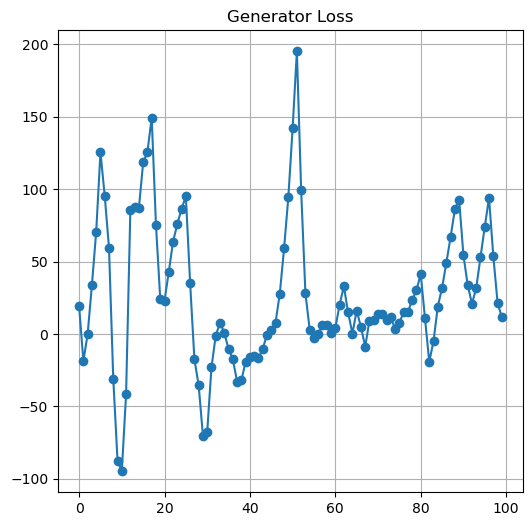

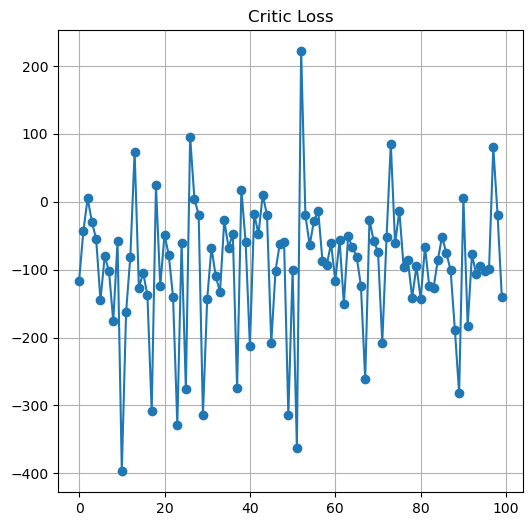

In [13]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)
generated_samples = train_and_generate(dataset_path, batch_size=32, epochs=100)

In [14]:
generated_df = pd.DataFrame(generated_samples, columns=scaled_data.columns)
df_unscaled = pd.DataFrame(scaler.inverse_transform(generated_df), columns=generated_df.columns)
ks_stats = compare_distributions(scaled_data, df_unscaled)

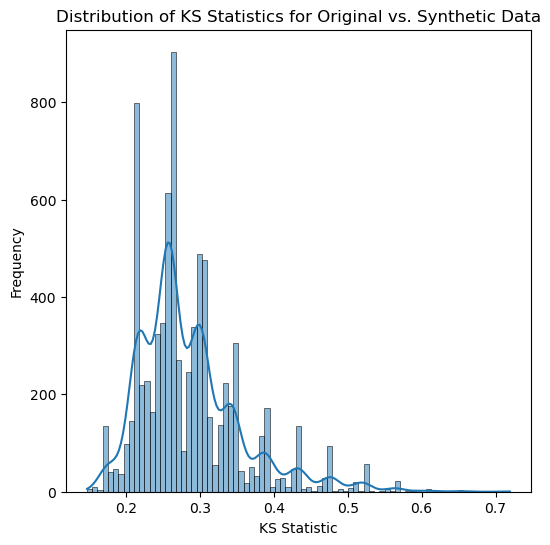

In [15]:
plt.figure(figsize=(6, 6))
sns.histplot(ks_stats['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

In [16]:
augmented_data_with_variance = recenter_data(df_unscaled, scaled_data)
ks_stats_with_added_variance = compare_distributions(scaled_data, augmented_data_with_variance)

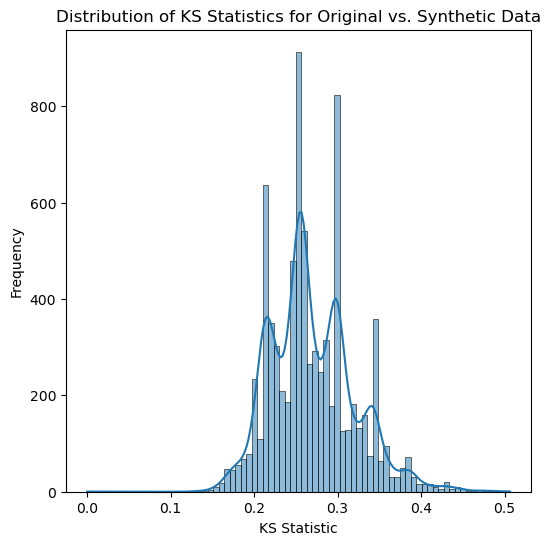

In [17]:
plt.figure(figsize=(6, 6))
sns.histplot(ks_stats_with_added_variance['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

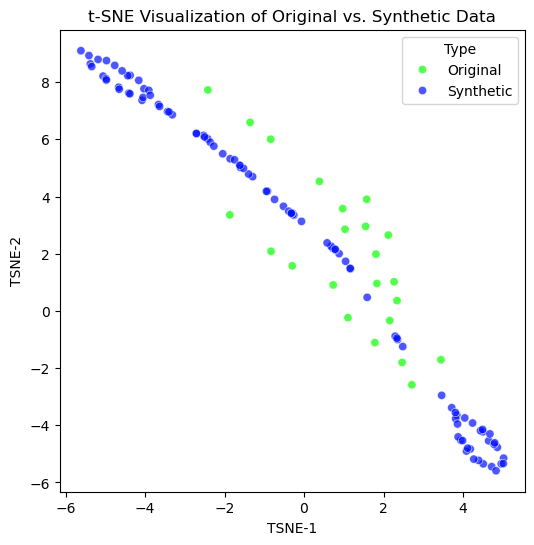

In [18]:
generate_tsne(scaled_data, augmented_data_with_variance)